In [0]:
pip -q install summa
from summa import summarizer

In [0]:
!pip -q install tensorflow==1.13.2
!pip -q install keras==2.2.4

     |████████████████████████████████| 92.6MB 45kB/s 
     |████████████████████████████████| 368kB 40.6MB/s 
     |████████████████████████████████| 3.2MB 57.4MB/s 
     |████████████████████████████████| 317kB 3.4MB/s 


In [0]:
import pandas as pd
import os, sys, email
import numpy as np 
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df=pd.read_csv('emails.csv')

In [0]:
#Citation: 
#Hanumanjunction. “Enron Emails Exploration.” Kaggle, Kaggle, 2 Feb. 2018, www.kaggle.com/hanumanjunction/enron-emails-exploration.
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': #extracting text data
            parts.append(part.get_payload())
    return ''.join(parts)

msgs = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
fields = msgs[0].keys()
for field in fields:
    df[field] = [doc[field] for doc in msgs]
df['content'] = list(map(get_text_from_email, msgs))

In [0]:
data=df[['Subject','content']]
data.head()

,Subject,content
0,,Here is our forecast\n\n
1,Re:,Traveling to have a business meeting takes the...
2,Re: test,test successful. way to go!!!
3,,"Randy,\n\n Can you send me a schedule of the s..."
4,Re: Hello,Let's shoot for Tuesday at 11:45.


In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
cd 'drive/My Drive/SI630/emailproject'

/content/drive/My Drive/SI630/emailproject


In [0]:
data.to_csv('data.csv')

In [0]:
data=pd.read_csv('data.csv')

In [0]:
print(len(data))

517401


In [0]:
subject_count=data.Subject.str.count(' ') + 1
content_count=data.content.str.count(' ') + 1

In [0]:
print('AVG subject length:',subject_count.mean(),"words")
print('AVG content length:',content_count.mean(),"words")

AVG subject length: 4.6946151653707044 words
AVG content length: 302.87751473228695 words


In [0]:
subject_count=subject_count.fillna(0)
content_count=content_count.fillna(0)

<Figure size 864x1080 with 0 Axes>

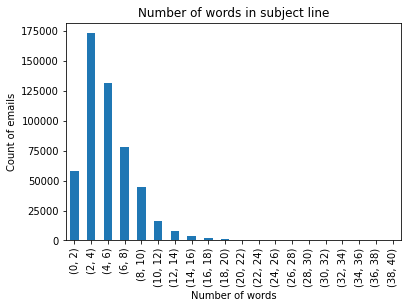

<Figure size 864x1080 with 0 Axes>

In [0]:
subject_count.value_counts(bins=75,sort=False)[:20].plot(kind='bar',xticks=[])
plt.xticks(ticks=range(0,20,1),labels=zip(range(0,40,2),range(2,42,2)),rotation=90)

plt.title("Number of words in subject line")
plt.xlabel("Number of words")
plt.ylabel("Count of emails")
plt.figure(figsize=(12,15))

<Figure size 864x1080 with 0 Axes>

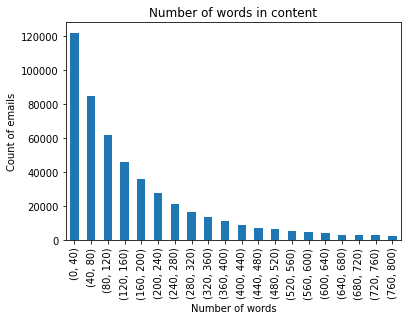

<Figure size 864x1080 with 0 Axes>

In [0]:
content_count.value_counts(bins=6240,sort=False)[:20].plot(kind='bar',xticks=[])
plt.xticks(ticks=range(0,20,1),labels=zip(range(0,800,40),range(40,840,40)),rotation=90)
plt.title("Number of words in content")
plt.xlabel("Number of words")
plt.ylabel("Count of emails")
plt.figure(figsize=(12,15))

In [0]:
data=data.dropna()

In [0]:
len(data)

498214

In [0]:
data=data[data['Subject'].apply(lambda x: x.count(' ')>4) & data['content'].apply(lambda x: x.count(' ')>40)]
data=data[data['Subject'].apply(lambda x: x.count(' ')<20) & data['content'].apply(lambda x:  x.count(' ')<400)]

In [0]:
len(data)

92065

In [0]:
data=data[data['Subject'].apply(lambda x: not x.startswith('Re:')) & data['content'].apply(lambda x: not x.startswith('-'))]
len(data)

69999

In [0]:
data=data[data['Subject'].apply(lambda x: not x.startswith('RE:'))]
len(data)

62024

In [0]:
data=data[data['Subject'].apply(lambda x: not x.startswith('FW:'))]
len(data)

54828

In [0]:
data=data[data['Subject'].apply(lambda x: not x.startswith('Re:')) & data['content'].apply(lambda x: not x.startswith(' '))]
len(data)

53294

In [0]:
data=data[~data['content'].str.contains('Forwarded by')]
len(data)

44634

In [0]:
data['content']=data['content'].apply(lambda x: x.lstrip().replace('[IMAGE]','').lower())
data['Subject']=data['Subject'].apply(lambda x: x.lstrip().replace('[IMAGE]','').lower())

In [0]:
data=data[['Subject','content']]

In [0]:
data.to_csv('email_cleaned.csv')

In [0]:
#split to train set and test set
cleaned_df=pd.read_csv('email_cleaned.csv')
msk = np.random.rand(len(cleaned_df)) < 0.9
train = cleaned_df[msk]
test = cleaned_df[~msk]
train.to_csv('train.csv')
test.to_csv('test.csv')

In [0]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [0]:
print(len(train),len(test))

40203 4431


In [0]:
#LEAD-2
def model1(data):
  data=data.lstrip()
  data=re.split('[?.,!:]', data)
  try: result=data[0]+data[1]
  except: result=data[0]
  return result.replace('\n','')

In [0]:
#TextRank
def model2(data):
  try: result=summarizer.summarize(data).partition('.')[0]
  except: result="NA"
  return result

In [0]:
from keras.preprocessing.text import Tokenizer
subject_len=15
content_len=300
vocab_size=5000


tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.content+train.Subject)
print(len(tokenizer.word_index))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

130657


In [0]:
word2idx=tokenizer.word_index

In [0]:
word2idx['enron']

14

In [0]:
content_seq=tokenizer.texts_to_sequences(train.content)
subject_seq=tokenizer.texts_to_sequences(train.Subject)

In [0]:
print(train.Subject.iloc[0],subject_seq[0])

new notice from transwestern pipeline co. [53, 260, 23, 2174, 642, 689]


In [0]:
print(train.content.iloc[0],content_seq[0])

transwestern pipeline co. posted new notice(s) since our last check at 
12/13/2000 3:30:01 pm, the newest notice looks like:

 capacity constraint, dec 13 2000  4:03pm, dec 14 2000  9:00am, dec 15 2000  
8:59am, 2241, allocation - san juan lateral

please click the following to go to the web site for detail.

http://ios.ets.enron.com/infopostings/shared/et_noncritical_notice.asp?company
=60 [2174, 642, 689, 860, 53, 260, 76, 519, 46, 190, 380, 19, 97, 305, 89, 54, 68, 36, 139, 1, 4219, 260, 2213, 158, 449, 694, 305, 89, 40, 694, 247, 89, 132, 1464, 694, 145, 89, 122, 1891, 579, 1956, 3182, 20, 65, 1, 115, 2, 204, 2, 1, 149, 214, 6, 2245, 32, 1003, 14, 11, 2275, 688, 260, 254, 105, 1107]


In [0]:
from keras.preprocessing.sequence import pad_sequences
content_pad = pad_sequences(content_seq, maxlen=content_len, padding='post', truncating='post')
subject_pad = pad_sequences(subject_seq, maxlen=subject_len, padding='post', truncating='post')

In [0]:
subject_pad[0]

array([  53,  260,   23, 2174,  642,  689,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [0]:
decoder_outputs = np.zeros((len(test), subject_len, vocab_size), dtype='float32')
decoder_outputs.shape

(4431, 15, 5000)

In [0]:
!unzip glove6b50dtxt.zip

Archive:  glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [0]:
ls

data.csv           glove6b200d.zip    HumanRating.ipynb
email_cleaned.csv  glove.6B.50d.txt   test.csv
email.ipynb        glove6b50dtxt.zip  train.csv


In [0]:
glove = {}
with open('glove.6B.50d.txt') as f:
    for line in f:
        d = line.split()
        word = d[0]
        vec = np.asarray(d[1:], dtype='float32')
        glove[word] = vec
    f.close()

In [0]:
idx2vec = np.zeros((len(word2idx), 50))
for word, i in word2idx.items():
  vec = glove.get(word)
  if vec is not None:
    idx2vec[i] = vec

In [0]:
import keras
from keras import backend as k
k.set_learning_phase(1)
from keras.preprocessing.text import Tokenizer
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import Sequential,Model
from keras.layers import TimeDistributed,Dense,LSTM,Dropout,Input,Activation,Add,concatenate, Embedding
from keras.layers.advanced_activations import LeakyReLU,PReLU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split



In [0]:
n_units=50
lr=0.01
batch_size = 200
epochs = 20

In [0]:
encoder_inputs = Input(shape=(content_len,))
encoder_embedding = Embedding(input_dim = len(word2idx), 
                                    output_dim = n_units,
                                    input_length = content_len,
                                    weights = [idx2vec],
                                    trainable = False)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(n_units, return_state=True)(encoder_embedding)
encoder_outputs_R, state_h_R, state_c_R = LSTM(n_units, return_state=True, go_backwards=True)(encoder_embedding)
final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

decoder_inputs = Input(shape=(subject_len,))
decoder_embedding = Embedding(input_dim = len(word2idx), 
                                    output_dim = n_units,
                                    input_length = subject_len,
                                    weights = [idx2vec],
                                    trainable = False)(decoder_inputs)
decoder_LSTM = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs,_,_ = decoder_LSTM(decoder_embedding, initial_state=encoder_states)
output = Dense(vocab_size, activation='linear')(decoder_outputs)
model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=output)


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
rmsprop = RMSprop(lr=lr)
model.compile(loss='mse', optimizer=rmsprop, metrics=["accuracy"])

In [0]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 50)      6532850     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  20200       embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LS

In [0]:
c_train, c_valid, s_train, s_valid = train_test_split(content_pad, subject_pad, test_size=0.2)

In [0]:
num_samples = len(subject_pad)
decoder_output_data = np.zeros((num_samples, subject_len, vocab_size), dtype="int32")

In [0]:
for i, seqs in enumerate(subject_pad):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1

In [0]:
train_num = c_train.shape[0]
train_num

32162

In [0]:
target_train = decoder_output_data[:train_num]
target_test = decoder_output_data[train_num:]

In [0]:
filepath = "model_weights_saved0428.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

In [0]:
history = model.fit([c_train, s_train], 
                     target_train, 
                     epochs=epochs, 
                     batch_size=batch_size,
                     validation_data=([c_valid, s_valid], target_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32162 samples, validate on 8041 samples
Epoch 1/20
32162/32162 [==============================] - 107s 3ms/step - loss: 1.8661e-04 - acc: 0.5240 - val_loss: 1.8652e-04 - val_acc: 0.5829
Epoch 2/20
32162/32162 [==============================] - 106s 3ms/step - loss: 1.1867e-04 - acc: 0.5324 - val_loss: 1.0283e-04 - val_acc: 0.5391
Epoch 3/20
32162/32162 [==============================] - 106s 3ms/step - loss: 1.0623e-04 - acc: 0.5000 - val_loss: 1.0228e-04 - val_acc: 0.5163
Epoch 4/20
32162/32162 [==============================] - 107s 3ms/step - loss: 1.0577e-04 - acc: 0.4983 - val_loss: 1.0190e-04 - val_acc: 0.5163
Epoch 5/20
32162/32162 [==============================] - 106s 3ms/step - loss: 1.0561e-04 - acc: 0.4983 - val_loss: 1.0416e-04 - val_acc: 0.5162
Epoch 6/20
32162/32162 [==============================] - 108s 3ms/step - loss: 1.0538e-04 - ac

In [0]:
model.save('model0428.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'add_1/add:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


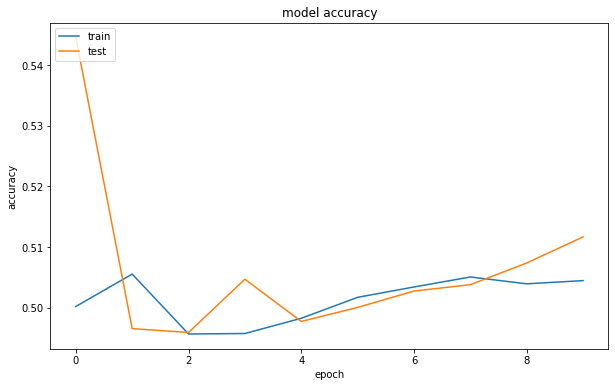

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

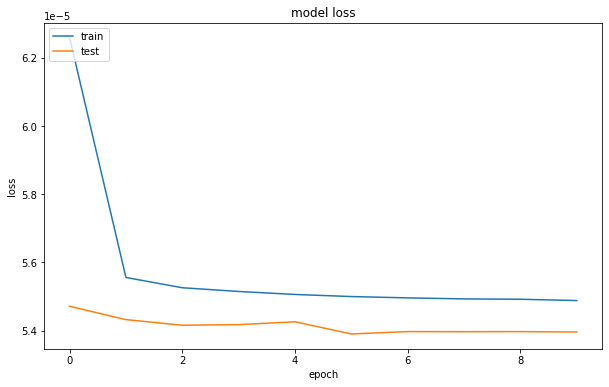

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import load_model
model3=load_model('model0428.h5')

In [0]:
result = model3.predict([c_valid, s_valid], verbose=1)


8041/8041 [==============================] - 16s 2ms/step


In [0]:
s_valid.shape

(8041, 15)

In [0]:
trans=np.argmax(result,axis=2)

In [0]:
trans.shape

(8041, 15)

In [0]:
idx2word={v: k for k, v in word2idx.items()}

In [0]:
out=np.vectorize(idx2word.get)(trans)

In [0]:
def model4(data):
  email_seq=tokenizer.texts_to_sequences(data)
  print(email_seq)

In [0]:
len(result[4][2])

10000

In [0]:
idx2word[5]

'for'

In [0]:
test['result1']=test['content'].apply(lambda x:model1(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
test['result1']

165               has been  placed on hold for you Phillip
250                                            Mr Shankman
306      Good MorningJust a reminder to get your AGA es...
385            Knowledge@Wharton Newsletterhttp//knowledge
430                       =09     Dear  Amazoncom Customer
                               ...                        
62851    The Approval status has changed on the followi...
62885                  =09 =09    Dear Andrew  On Thursday
62897    THE STANDISH GROUP - TOUCH OF CHAOS 2002Dear A...
62982    EnronOnlineTrade Counts and Volume for April 3...
63019    Small issue but annoyingIf try to modify a plo...
Name: result1, Length: 622, dtype: object

In [0]:
test['result2']=test['content'].apply(lambda x:model2(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
test['result2']

165      Just click here   to find out how to receive y...
250      In preparation for the meeting on December 11t...
306      Ce message et toutes les pieces jointes (ci-ap...
385           Knowledge@Wharton Newsletterhttp://knowledge
430                                           Dear  Amazon
                               ...                        
62851    The Approval status has changed on the followi...
62885    nergy and Williams Energy, the parent company ...
62897    YOU ARE CORDIALLY INVITED TO PARTICIPATE IN A ...
62982    USA\tCrude\tFinancial\t      169 \t      8,505...
63019    If try to modify a plo by going to the line an...
Name: result2, Length: 622, dtype: object

In [0]:
test.to_csv('result.csv')

In [0]:
testsize=10
r1,r2,r3,r4=[],[],[],[]
print("0=bad,1=good\n")
sample=test.sample(testsize)
for i in range(testsize):
  print("/////////////////Content://////////////////////////////\n",sample.content.iloc[i][:500])
  print("///////////////////////////////////////////////////////")
  print("************Subject line 1:*********\n",sample.result1.iloc[i])
  print("***************************************************")
  print("Score:")
  r1.append(int(input()))
  print("************Subject line 2:*********\n",sample.result2.iloc[i])
  print("***************************************************")
  print("Score:")
  r2.append(int(input()))
  print("************Subject line 3:*********\n",sample.result1.iloc[i])
  print("***************************************************")
  print("Score:")
  r3.append(int(input()))
  print("************Subject line 4:*********\n",sample.Subject.iloc[i])
  print("***************************************************")
  print("Score:")
  r4.append(int(input()))
  
print("final result model1:",sum(r1))
print("final result model2:",sum(r2))
print("final result model3:",sum(r3))
print("final result model3:",sum(r4))

0=bad,1=good

/////////////////Content://////////////////////////////
 Dear Power Outage Database Customer,

Attached you will find an excel document. The outages contained within
are forced or rescheduled outages. Your daily delivery will still
contain these outages.

In addition to the two excel documents, there is a dbf file that is
formatted like your daily deliveries you receive nightly. This will
enable you to load the data into your regular database. Any questions
please let me know.
Thanks.

Greg Elliott
IIR, Inc.
713-783-5147 x 3481
outages@industrialinfo.
///////////////////////////////////////////////////////
************Subject line 1:*********
 Dear Power Outage Database CustomerAttached you will find an excel document
***************************************************
Score:
1
************Subject line 2:*********
 The outages contained within
contain these outages
***************************************************
Score:
1
************Subject line 3:*********
 Dear Powe

KeyboardInterrupt: ignored

In [0]:
model1[7,7,8,6,9]:0.740
